# Attention on VGGNet (Saliency and grad-CAM)

## Saliency

#К сожалению не получилось запустить вариант кода, который представлен в примере, поэтому на его основе создан тот, который представлен ниже.

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear'.

In [1]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.8 MB/s eta 0:00:00


In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
model = Model(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 3s 0us/step


Используем данную подборку (https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000/data) с 1000 изображениями imagenet, чтобы использовать 4 из них для данной работы

Lets load a couple of test images to try saliency.

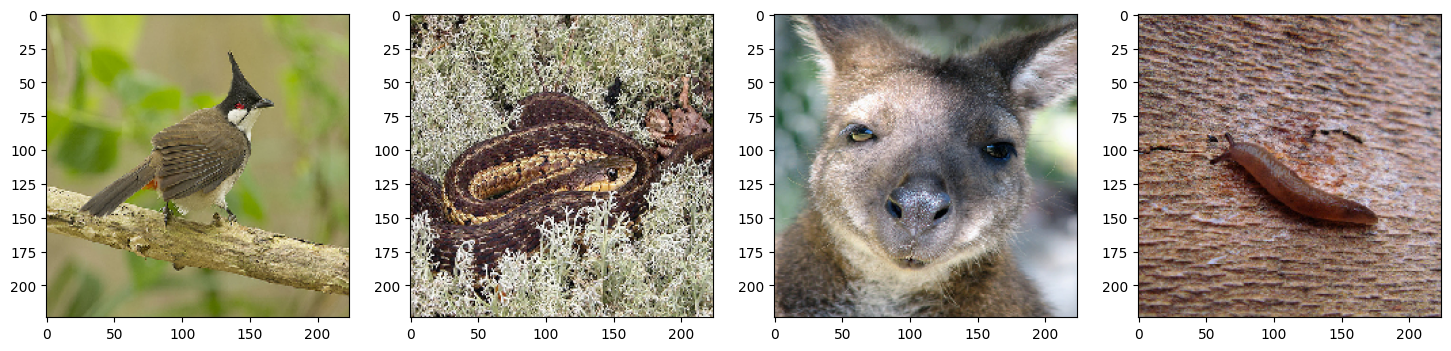

In [5]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = load_img('/content/1.JPEG', target_size=(224, 224))
img2 = load_img('/content/2.JPEG', target_size=(224, 224))
img3 = load_img('/content/3.JPEG', target_size=(224, 224))
img4 = load_img('/content/4.JPEG', target_size=(224, 224))

f, ax = plt.subplots(1, 4)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)
ax[3].imshow(img4)

names = ['1', '2', '3', '4']
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])
X = preprocess_input(images)

Time for saliency visualization.

In [6]:
#!git clone --branch=0.4.1 https://github.com/raghakot/keras-vis.git
#!cd keras-vis/
#!git cherry-pick 39e775
#!pip install .

#!pip install git+https://github.com/raghakot/keras-vis.git -U

#!pip install -I scipy==1.2.*
#!pip install git+https://github.com/raghakot/keras-vis.git -U

#!pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps

#!python vis/visualization/__init__.py

#!pip install https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.11.0-py3-none-any.whl

#!python setup.py
#!python vis/visualization/activation_maximization.py

#!pip install keras-core
#import keras_core as keras

#!git clone https://github.com/ivanmontero/visualize-saliency.git

#from vis.utils import utils
#from vis.visualization import visualize_saliency, overlay
#from keras.layers import Activation
#from keras import activations

# Utility to search for layer index by name.
# Alternatively we can specify this as -1 since it corresponds to the last layer.
#layer_idx = utils.find_layer_idx(model, 'predictions')

#f, ax = plt.subplots(1, 4)
#for i, img in enumerate([img1, img2, img3, img4]):
    # 20 is the imagenet index corresponding to `ouzel`
#    grads = visualize_saliency(model, layer_idx, filter_indices=20, seed_input=img)

    # visualize grads as heatmap
#    ax[i].imshow(grads, cmap='jet')


from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear() # заменяем функцию на лицейную функцию активации
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear


from tf_keras_vis.utils.scores import CategoricalScore
score = CategoricalScore([14, 24, 34, 44])
def score_function(output):
    return (output[0][14], output[1][24], output[2][34], output[3][44])

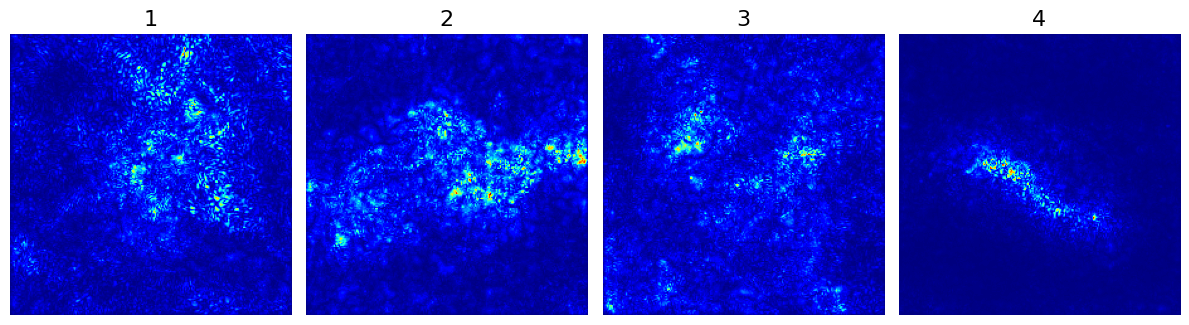

In [7]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

saliency = Saliency(model, model_modifier=replace2linear, clone=True)

saliency_map = saliency(score, X)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(names):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

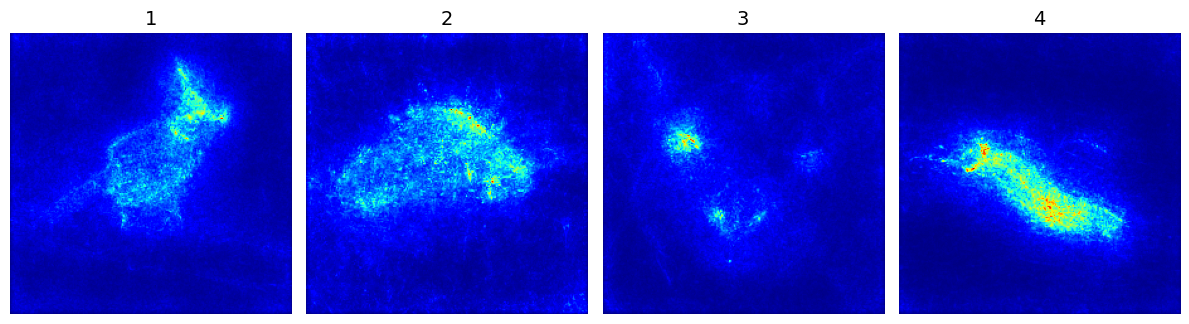

In [8]:
saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(names):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

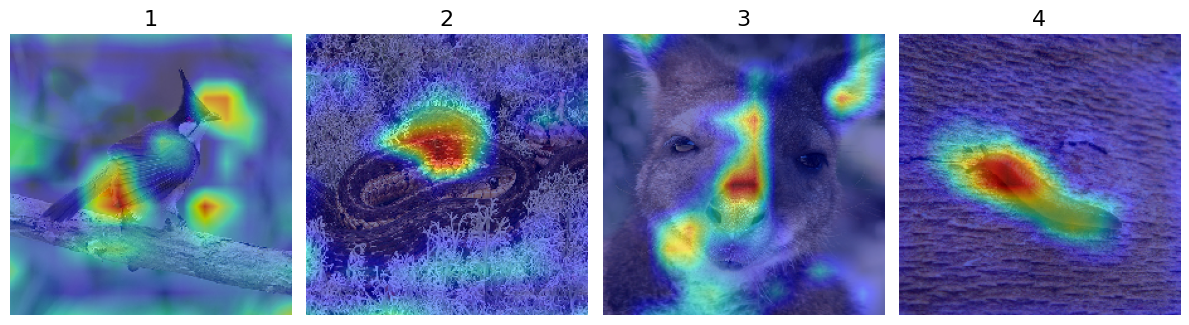

In [9]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)

cam = gradcam(score, X, penultimate_layer=-1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(names):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

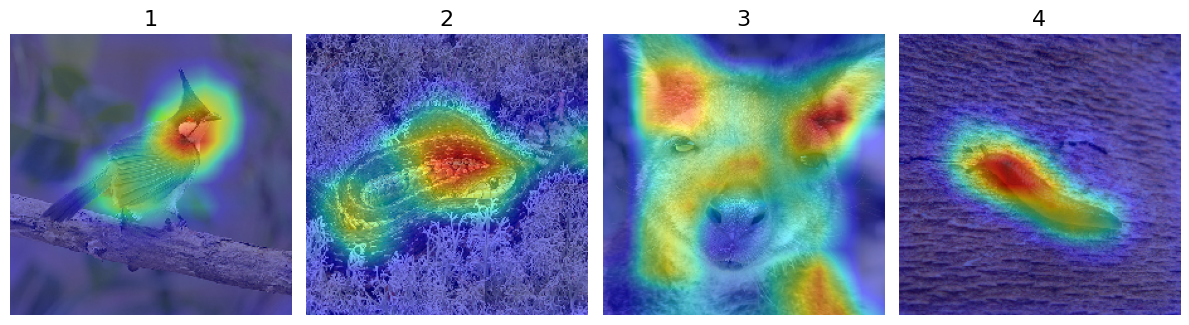

In [10]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

gradcam = GradcamPlusPlus(model, model_modifier=replace2linear, clone=True)

cam = gradcam(score, X, penultimate_layer=-1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(names):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()